In [19]:
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN,LSTM
from keras.optimizers import Adam, SGD
from sklearn.preprocessing import StandardScaler,MinMaxScaler 
from keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split
from keras.losses import MeanSquaredLogarithmicError,MeanSquaredError,MeanAbsolutePercentageError,Huber
from keras.metrics import RootMeanSquaredError,mean_squared_error
import matplotlib.pyplot as plt
from datetime import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import joblib


In [2]:
def pasar_a_datetime(fecha):
    #format_string = '%Y-%m-%d'
    anio,mes,dia= fecha.split('-')
    aux_dia = dia.split(' ')
    if len(aux_dia)>1:dia = aux_dia[0]
    res = datetime(int(anio),int(mes),int(dia))
    return res

In [3]:
def scale_datasets(x_train, x_test):
    #min_max = MinMaxScaler ()
    stdscaler = StandardScaler()
    x_train_scaled = pd.DataFrame(
        stdscaler.fit_transform(x_train),
        columns=x_train.columns
    )
    x_test_scaled = pd.DataFrame(
        stdscaler.transform(x_test),
        columns = x_test.columns
    )
    return x_train_scaled, x_test_scaled,stdscaler

In [4]:
def ordenar_fecha(data):
    data['fecha_mediana'] = data['fecha_mediana'].map(lambda x: pasar_a_datetime(x))
    data.sort_values(by='fecha_mediana',inplace=True)

In [5]:
def preparar_datos_entrenamiento(X_train, X_test):
    x_train_scaled, x_test_scaled,stdscaler = scale_datasets(X_train, X_test)
    return x_train_scaled, x_test_scaled,stdscaler 

In [6]:
def spliteo_data(datos, split_training):
    cols = datos.columns.to_list()
    idx = cols.index('Fuente')
    x_cols = cols[:idx+1]+cols[-2:]
    y_cols = cols[idx+2:-2]

    x = datos.loc[:,x_cols]
    y = datos.loc[:,y_cols]
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=split_training,shuffle=True,random_state=2023)
    
    return X_train, X_test, y_train, y_test,x_cols,y_cols

In [7]:
data_primera_vuelta = pd.read_csv('C:/Users/54911/OneDrive/Escritorio/Data Science/Elecciones + IA/modeling/Preparando_datos/data_primera_vuelta.csv')
data_solo_ballotaje = pd.read_csv('C:/Users/54911/OneDrive/Escritorio/Data Science/Elecciones + IA/modeling/Preparando_datos/data_solo_ballotaje.csv')
data_encuestas_poly = pd.read_csv('C:/Users/54911/OneDrive/Escritorio/Data Science/Elecciones + IA/modeling/Preparando_datos/data_encuestas_poly.csv')
data_ballotaje_poly = pd.read_csv('C:/Users/54911/OneDrive/Escritorio/Data Science/Elecciones + IA/modeling/Preparando_datos/data_ballotaje_poly.csv')

In [8]:
ordenar_fecha(data_primera_vuelta)
ordenar_fecha(data_solo_ballotaje)
ordenar_fecha(data_encuestas_poly)
ordenar_fecha(data_ballotaje_poly)

# Redes Neuronales

In [9]:
def seleccionar_datos_partido(datos,partido):
    Encuesta_col = partido + '_Encuestas'
    fecha = ['dia', 'mes']
    fuente = 'Fuente'
    datos = datos[datos[partido]!=0]
    x = datos[fecha+[partido]+[fuente]]
    y = datos[[Encuesta_col]]
    return x,y

In [10]:
def graficar(x,y,model,stdscaler,partido):
    plt.figure(figsize=(15,6))
    x_scaled = stdscaler.transform(x)
    predicted = model.predict(x_scaled)
    
    xlen = np.arange(len(x))
    plt.scatter(xlen, predicted,  label="Predicho",color="purple",s=5)
    plt.scatter(xlen, y,label="Esperado",color='green',s=10)
    plt.title(partido)
    plt.legend()

In [11]:
def graficar_nro_partidos(datos,x_cols,y_cols,stdscaler,model):
    nro_partidos=5
    fig, ax = plt.subplots(nro_partidos,1,figsize=(12,5*nro_partidos))
    x = datos.loc[:,x_cols]
    y = datos.loc[:,y_cols]
    x_scaled = stdscaler.transform(x)
    predicted = model.predict(x_scaled)
    
    xlen = np.arange(len(x))
    for i,a in enumerate(ax.flatten()):
        a.scatter(xlen, predicted[:,i],  label="Predicho",color="purple",s=5)
        a.scatter(xlen, y.iloc[:,i],label="Esperado",color='green',s=10)
    plt.legend()

In [12]:
def modelo_arquitectura(in_dim,out_dim,learning_rate):
    metrica = RootMeanSquaredError()
    perdida = MeanSquaredError()

    model = Sequential()
    model.add(Dense(units=in_dim,input_dim=in_dim,activation='softplus'))
    model.add(Dense(units=(in_dim+out_dim)//2,activation='softplus'))
    model.add(Dense(units=out_dim, activation='softplus')) 
    model.compile(loss=perdida, 
                optimizer=SGD(learning_rate=learning_rate,
                              momentum=0.8), 
                metrics=[metrica]) 
    
    return model

In [13]:
def entrenar(datos, split_training,partido):
    #X_train, X_test, y_train, y_test = spliteo_data(datos, split_training)
    ########## PROBANDO CON UN SOLO PARTIDO   ###############
    #x,y = seleccionar_datos_partido(datos,partido)
    learning_rate = 0.0005
    ciclos = 300
    X_train, X_test, y_train, y_test,x_cols,y_cols= spliteo_data(datos, split_training)
    
    x_train_scaled, x_test_scaled,stdscaler = preparar_datos_entrenamiento(X_train, X_test)

    in_dim=X_train.shape[-1]
    out_dim=y_train.shape[1]
    
    
    model = modelo_arquitectura(in_dim, out_dim,learning_rate)

    model.fit(x_train_scaled,y_train, epochs=ciclos, verbose=1,batch_size=16)
    

    #graficar(x,y,model,stdscaler,partido)
    #graficar_nro_partidos(datos,x_cols,y_cols,stdscaler,model)

    return model,
    

# Creamos modelo definitivo

In [14]:
learning_rate = 0.0005
ciclos = 300

In [15]:
def seleccionar_datos(datos):
    cols = datos.columns.to_list()
    idx = cols.index('Fuente')
    x_cols = cols[:idx+1]+cols[-2:]
    y_cols = cols[idx+2:-2]

    x = datos.loc[:,x_cols]
    y = datos.loc[:,y_cols]
    return x,y

In [16]:
x,y = seleccionar_datos(data_encuestas_poly)
model = modelo_arquitectura(8, 5,learning_rate)
std_scaler = StandardScaler()
x_scaled = std_scaler.fit_transform(x)
model.fit(x_scaled,y, epochs=ciclos, verbose=0,batch_size=16)

In [18]:
x.columns

Index(['Union por la Patria', 'Juntos por el Cambio', 'La Libertad Avanza',
       'Hacemos juntos nuestro Pais', 'Frente de Izquierda y Trabajadores',
       'Fuente', 'dia', 'mes'],
      dtype='object')

In [21]:
joblib.dump(std_scaler, 'C:/Users/54911/OneDrive/Escritorio/Data Science/Elecciones + IA/modeling/scaler_primeravuelta.gz')
model.save('C:/Users/54911/OneDrive/Escritorio/Data Science/Elecciones + IA/modeling/modelo_primera_vuelta')

INFO:tensorflow:Assets written to: C:/Users/54911/OneDrive/Escritorio/Data Science/Elecciones + IA/modeling/modelo_primera_vuelta\assets


INFO:tensorflow:Assets written to: C:/Users/54911/OneDrive/Escritorio/Data Science/Elecciones + IA/modeling/modelo_primera_vuelta\assets


53/53 [==============================] - 1s 6ms/step


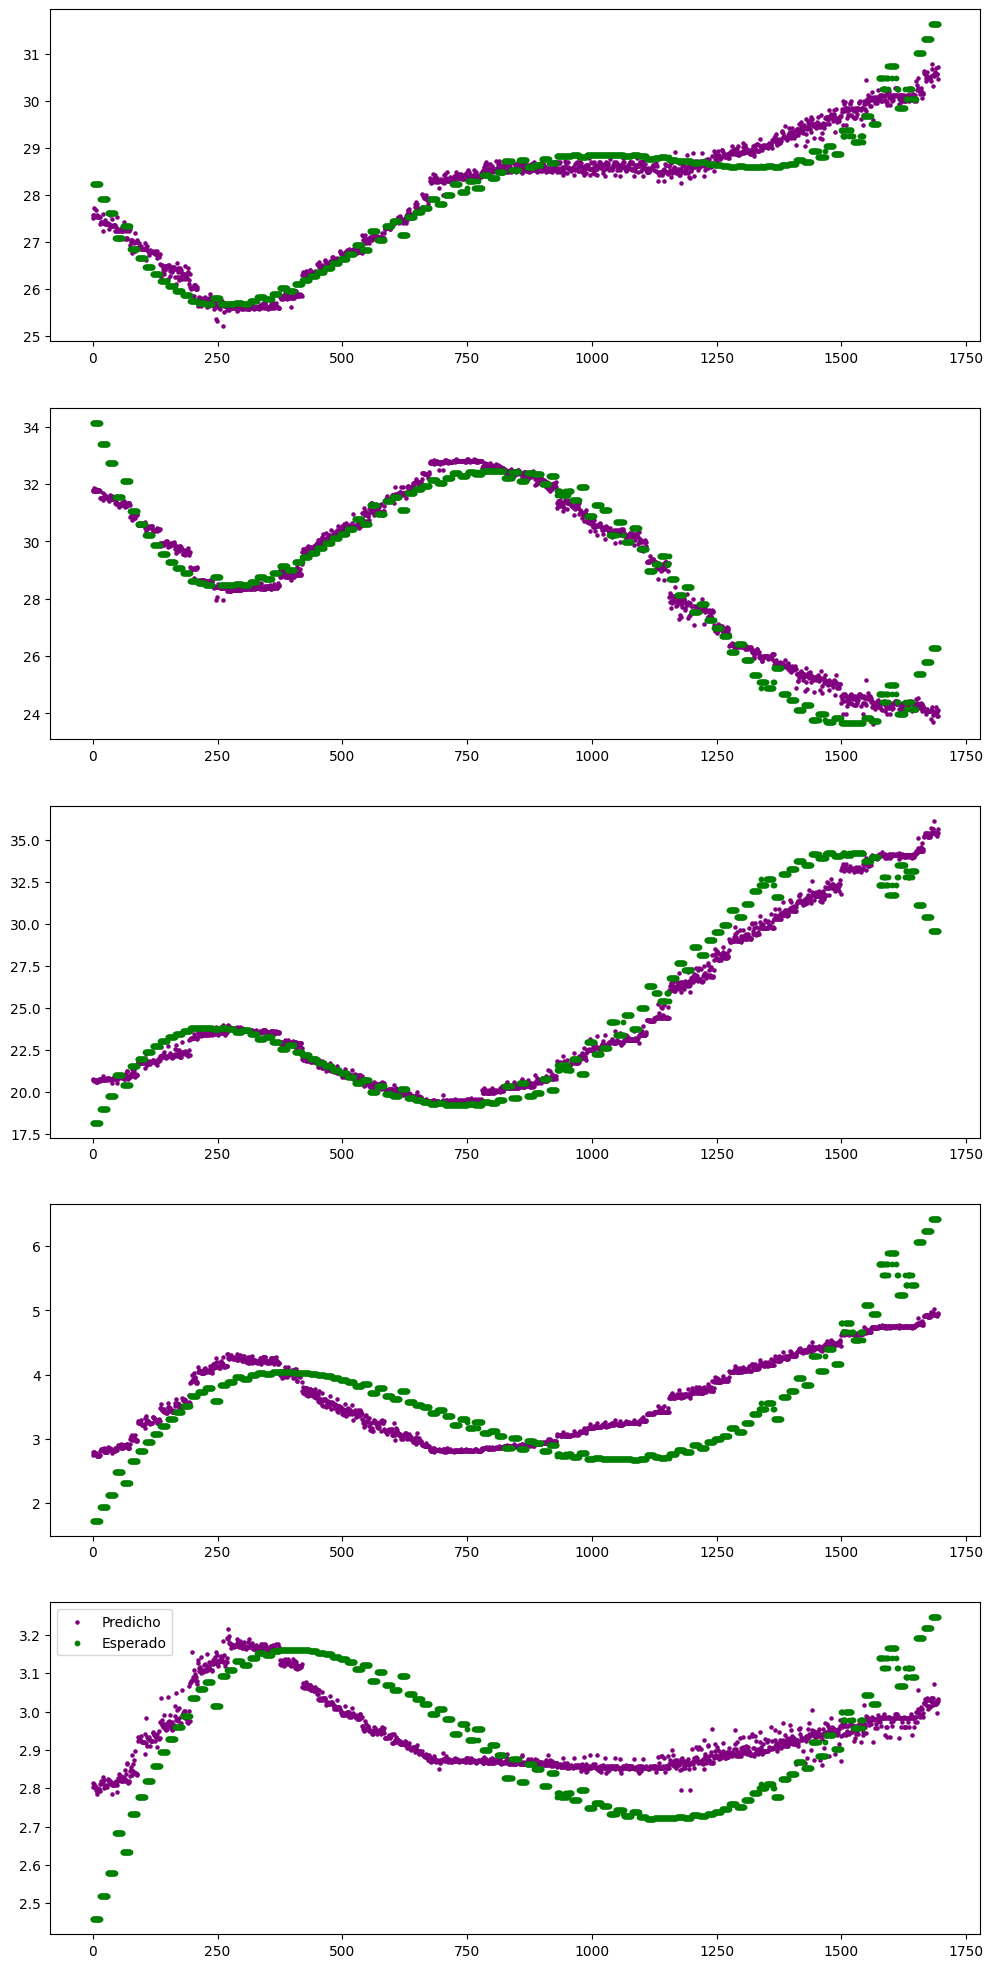

In [17]:
nro_partidos=5
fig, ax = plt.subplots(nro_partidos,1,figsize=(12,5*nro_partidos))

predicted = model.predict(x_scaled)

xlen = np.arange(len(x))
for i,a in enumerate(ax.flatten()):
    a.scatter(xlen, predicted[:,i],  label="Predicho",color="purple",s=5)
    a.scatter(xlen, y.iloc[:,i],label="Esperado",color='green',s=10)
plt.legend()

In [20]:
x,y = seleccionar_datos(data_ballotaje_poly)
model = modelo_arquitectura(5, 2,learning_rate)
std_scaler = StandardScaler()
x_scaled = std_scaler.fit_transform(x)
model.fit(x_scaled,y, epochs=ciclos, verbose=0,batch_size=16)
model.save('C:/Users/54911/OneDrive/Escritorio/Data Science/Elecciones + IA/modeling/modelo_ballotaje')
joblib.dump(std_scaler, 'C:/Users/54911/OneDrive/Escritorio/Data Science/Elecciones + IA/modeling/scaler_ballotaje.gz')

INFO:tensorflow:Assets written to: C:/Users/54911/OneDrive/Escritorio/Data Science/Elecciones + IA/modeling/modelo_ballotaje\assets


INFO:tensorflow:Assets written to: C:/Users/54911/OneDrive/Escritorio/Data Science/Elecciones + IA/modeling/modelo_ballotaje\assets


['C:/Users/54911/OneDrive/Escritorio/Data Science/Elecciones + IA/modeling/scaler_ballotaje.gz']